In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt
import gcsfs
import numpy as np
import xarray as xr

In [2]:
gen = np.random.default_rng(1315)

In [3]:
perm = gen.permutation(262)
train_indx = perm[0:184]
val_indx = perm[184:223]
test_indx = perm[223:]

In [4]:
fs = gcsfs.GCSFileSystem()

In [5]:
param_xr = xr.open_dataset('parameter_262_w_control.nc')

In [6]:
param_df = param_xr.to_pandas()
param_df = param_df.drop('Sample_nmb', axis=1).drop(175, axis=0)

In [7]:
param_std_df = (param_df - param_df.min()) / (param_df.max() - param_df.min())

In [8]:
param_np = param_std_df.values

In [9]:
train_params = param_np[train_indx]
val_params = param_np[val_indx]
test_params = param_np[test_indx]

In [10]:
train_stacked = torch.tensor(np.repeat(train_params, repeats=36, axis=0))
val_stacked = torch.tensor(np.repeat(val_params, repeats=36, axis=0))
test_stacked = torch.tensor(np.repeat(test_params, repeats=36, axis=0))

In [11]:
mapper = fs.get_mapper("gs://leap-persistent/yiqioyang/cam6_PD_monthly_prec.zarr")
prec_ppe_xr = xr.open_dataset(mapper, engine = 'zarr')

In [12]:
prec_ppe_xr = prec_ppe_xr.chunk({'ensemble': 262, 'time': 36, 'lat': 64, 'lon': 64})

In [13]:
prec_ppe_xr['PRECC']

<xarray.DataArray 'PRECC' (ensemble: 262, time: 36, lat: 192, lon: 288)> Size: 2GB
dask.array<xarray-PRECC, shape=(262, 36, 192, 288), dtype=float32, chunksize=(262, 36, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Convective precipitation rate (liq + ice)
    units:         m/s

In [14]:
prect_ppe = prec_ppe_xr['PRECC'] + prec_ppe_xr['PRECL']

In [15]:
prect_ppe.name = 'PRECT'
prect_ppe = prect_ppe.assign_attrs(units='mm/day')

In [16]:
prect_ppe = prect_ppe * (60 * 60 * 24 * 1000.)

In [17]:
prect_ppe = prect_ppe.compute()

In [18]:
fs.ls('gs://leap-persistent/kylemcevoy')

['leap-persistent/kylemcevoy/amip_prec_q90.zarr',
 'leap-persistent/kylemcevoy/cam6_pd_monthly_flut_ppe.zarr',
 'leap-persistent/kylemcevoy/cam6_pd_monthly_fsntoa_ppe.zarr',
 'leap-persistent/kylemcevoy/cam6_pd_ppe_prect.zarr',
 'leap-persistent/kylemcevoy/ceres_glob_mean.zarr',
 'leap-persistent/kylemcevoy/ceres_toa.zarr',
 'leap-persistent/kylemcevoy/cesm2_le50_prec_quantile090.nc',
 'leap-persistent/kylemcevoy/cesm2_le50_prec_quantile095.nc',
 'leap-persistent/kylemcevoy/cesm2_le_prec_quantile095.nc',
 'leap-persistent/kylemcevoy/cesm2_ppe_param_set.zarr',
 'leap-persistent/kylemcevoy/fsnt_ppe_glob_mean.zarr',
 'leap-persistent/kylemcevoy/prect_binned_ppe.zarr',
 'leap-persistent/kylemcevoy/satellite_climatologies_Nov2019.zarr',
 'leap-persistent/kylemcevoy/tropics_prect_target.zarr']

In [19]:
train_target = torch.tensor(np.ravel(prect_ppe.sel(lat = 0, lon = 0, method='nearest').
                                     values[train_indx, :]),
                           dtype=torch.float64)
val_target = torch.tensor(np.ravel(prect_ppe.sel(lat = 0, lon = 0, method='nearest').
                                   values[val_indx, :]),
                         dtype=torch.float64)
test_target = torch.tensor(np.ravel(prect_ppe.sel(lat = 0, lon = 0, method='nearest').
                                    values[test_indx, :]),
                          dtype=torch.float64)

In [20]:
train_target.dtype

torch.float64

In [21]:
train_stacked.dtype

torch.float64

In [22]:
train_data = TensorDataset(train_stacked, train_target)
val_data = TensorDataset(val_stacked, val_target)
test_data = TensorDataset(test_stacked, test_target)

In [23]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [24]:
device='cpu'

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(45, 35),
            nn.ReLU(),
            nn.Linear(35, 1)
        )
        self.double()

    def forward(self, x):
        preds = self.linear_relu_stack(x)
        return preds

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=45, out_features=35, bias=True)
    (1): ReLU()
    (2): Linear(in_features=35, out_features=1, bias=True)
  )
)


In [26]:
#adapted from https://github.com/Javicadserres/wind-production-forecast/blob/main/src/model/losses.py

class PinballLoss(nn.Module):
    """
    Calculates the quantile loss function.

    Attributes
    ----------
    self.pred : torch.tensor
        Predictions.
    self.target : torch.tensor
        Target to predict.
    self.quantiles : torch.tensor
    """
    def __init__(self, quantile):
        super(PinballLoss, self).__init__()
        self.pred = None
        self.targes = None
        self.quantile = quantile
        
    def forward(self, pred, target):
        """
        Computes the loss for the given prediction.
        """
        error = target - pred
        over =  self.quantile * error
        under = (1 - self.quantile) * -error 

        losses = torch.max(over, torch.tensor(0)) + torch.max(under, torch.tensor(0))
        loss = torch.mean((losses))
        return loss

In [27]:
loss_fn = PinballLoss(0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [29]:
def val(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred.squeeze(), y).item()
    val_loss /= num_batches
    print(f"Avg val. loss: {val_loss:>8f} \n")

In [30]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(), y).item()
    test_loss /= num_batches
    print(f'Avg test loss: {test_loss:>8f} \n')

In [43]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.392008  [  128/ 6624]
loss: 0.438108  [  256/ 6624]
loss: 0.518871  [  384/ 6624]
loss: 0.552551  [  512/ 6624]
loss: 0.395854  [  640/ 6624]
loss: 0.413362  [  768/ 6624]
loss: 0.392247  [  896/ 6624]
loss: 0.456821  [ 1024/ 6624]
loss: 0.466816  [ 1152/ 6624]
loss: 0.365722  [ 1280/ 6624]
loss: 0.427273  [ 1408/ 6624]
loss: 0.364866  [ 1536/ 6624]
loss: 0.387943  [ 1664/ 6624]
loss: 0.399020  [ 1792/ 6624]
loss: 0.371550  [ 1920/ 6624]
loss: 0.397969  [ 2048/ 6624]
loss: 0.375105  [ 2176/ 6624]
loss: 0.431779  [ 2304/ 6624]
loss: 0.416336  [ 2432/ 6624]
loss: 0.492246  [ 2560/ 6624]
loss: 0.374552  [ 2688/ 6624]
loss: 0.456364  [ 2816/ 6624]
loss: 0.342306  [ 2944/ 6624]
loss: 0.372889  [ 3072/ 6624]
loss: 0.314912  [ 3200/ 6624]
loss: 0.369672  [ 3328/ 6624]
loss: 0.494392  [ 3456/ 6624]
loss: 0.412491  [ 3584/ 6624]
loss: 0.372754  [ 3712/ 6624]
loss: 0.389774  [ 3840/ 6624]
loss: 0.485825  [ 3968/ 6624]
loss: 0.452237  [ 4096/ 6624]


In [44]:
test(test_loader, model, loss_fn)

Avg test loss: 0.372742 



In [45]:
with torch.no_grad():
    test_pred = model(test_stacked)

In [46]:
pred_quantiles = test_pred.numpy().reshape(39, 36)[:, 0]

In [47]:
test_y = test_target.numpy()

In [48]:
1404 / 36

39.0

In [49]:
test_quantiles = np.quantile(test_y.reshape(39, 36), q=0.9, axis=1)

In [50]:
max_val = np.max(np.hstack([pred_quantiles, test_quantiles]))
lin_space = np.linspace(0, max_val)

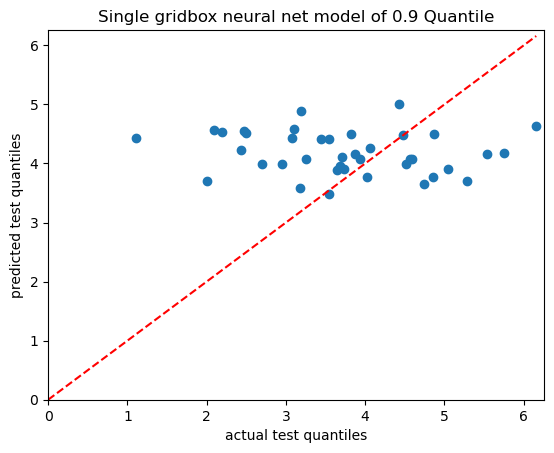

In [52]:
plt.scatter(test_quantiles, pred_quantiles)
ax = plt.gca()
ax.set_xlim([0, max_val + 0.1])
ax.set_ylim([0, max_val + 0.1])
plt.plot(lin_space, lin_space, linestyle='--', color='red')
plt.title('Single gridbox neural net model of 0.9 Quantile')
plt.xlabel('actual test quantiles')
plt.ylabel('predicted test quantiles')
plt.savefig('images/pred_vs_actual_snn.png')

In [53]:
np.corrcoef(test_quantiles, pred_quantiles)

array([[ 1.        , -0.14751917],
       [-0.14751917,  1.        ]])

In [40]:
test_indx

array([  9,  11, 164,  66,  62,  96, 199, 222,  19,  85, 130,  21,  32,
       168,  29, 139, 105, 183, 101, 118,   6, 108, 161,  35,  76, 258,
        18, 120,   4, 111, 201, 115, 215, 244,  24,   0, 239,  82,  13])

In [41]:
(prect_ppe.sel(lat = 0, lon = 0, method='nearest').
                                     values[9, :])

array([1.8088171 , 2.5290573 , 2.8679428 , 4.2440004 , 2.1739757 ,
       0.16070017, 0.1156073 , 0.13120396, 0.10404599, 0.919337  ,
       3.7448294 , 4.5827184 , 1.8237379 , 1.7299502 , 4.937255  ,
       4.3976483 , 2.880708  , 0.15715176, 0.13847332, 0.10119603,
       0.09012216, 0.14704245, 1.4116828 , 4.208869  , 4.0224214 ,
       3.1005902 , 6.9280863 , 4.4621987 , 1.845075  , 0.20305163,
       0.12005737, 0.11408172, 0.173009  , 0.2855067 , 2.9727008 ,
       4.3257575 ], dtype=float32)